In [1]:
import numpy as np
import pandas as pd
import keras.backend as K

from keras.models import Model, Sequential
from keras import models, layers, optimizers, regularizers
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.utils.np_utils import to_categorical
from keras.engine.topology import Layer, InputSpec

from sklearn.utils import shuffle
from sklearn.utils.linear_assignment_ import linear_assignment

import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K

/home/dougwoodward/CADS/thesis/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
kepler_data = pd.read_csv("kepler_data_full.csv", header=159)
kepler_data

,rowid,kepid,tce_plnt_num,tce_rogue_flag,tce_delivname,rowupdate,tce_datalink_dvs,tce_datalink_dvr,tce_period,tce_period_err,...,tce_dicco_mdec,tce_dicco_mdec_err,tce_dicco_msky,tce_dicco_msky_err,tce_dikco_mra,tce_dikco_mra_err,tce_dikco_mdec,tce_dikco_mdec_err,tce_dikco_msky,tce_dikco_msky_err
0,1,1162345,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001162/001162345/dv/kplr001162345-002-2014...,001/001162/001162345/dv/kplr001162345-20141002...,0.831850,6.693070e-05,...,0.504060,1.2900,0.507070,1.1200,-0.183490,1.2100,0.424890,1.3000,0.462820,1.1000
1,2,1292087,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001292/001292087/dv/kplr001292087-002-2014...,001/001292/001292087/dv/kplr001292087-20141002...,1.095240,1.009340e-05,...,-0.075798,0.2120,0.097899,0.2090,0.206520,0.2250,-0.077214,0.2380,0.220490,0.2200
2,3,1293031,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001293/001293031/dv/kplr001293031-002-2014...,001/001293/001293031/dv/kplr001293031-20141002...,0.719273,1.388330e-05,...,0.337380,0.2890,0.444500,0.2240,-0.308090,0.1910,0.283570,0.2240,0.418720,0.2070
3,4,1162345,3,NaN,q1_q17_dr24_tce,2015-01-15,001/001162/001162345/dv/kplr001162345-003-2014...,001/001162/001162345/dv/kplr001162345-20141002...,0.831833,9.431020e-06,...,0.167200,0.1830,0.253410,0.1970,0.087066,0.2510,0.106320,0.1720,0.137420,0.1960
4,5,1164109,1,NaN,q1_q17_dr24_tce,2015-01-15,001/001164/001164109/dv/kplr001164109-001-2014...,001/001164/001164109/dv/kplr001164109-20141002...,622.408000,8.547390e-03,...,10.358000,0.0894,15.177000,0.0893,-11.060000,0.0892,10.437000,0.0894,15.207000,0.0893
5,6,757450,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000757/000757450/dv/kplr000757450-001-2014...,000/000757/000757450/dv/kplr000757450-20141002...,8.884920,1.186150e-06,...,0.072221,0.0697,0.072362,0.0694,0.069581,0.0719,-0.103820,0.0782,0.124980,0.0763
6,7,892667,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000892/000892667/dv/kplr000892667-001-2014...,000/000892/000892667/dv/kplr000892667-20141002...,2.262110,2.726600e-05,...,0.303870,0.1920,0.411080,0.1370,0.139510,0.0883,0.115410,0.1630,0.181060,0.1240
7,8,892772,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000892/000892772/dv/kplr000892772-001-2014...,000/000892/000892772/dv/kplr000892772-20141002...,5.092600,3.144550e-05,...,-1.296300,0.1230,4.920200,0.1610,-4.962200,0.1580,-1.555100,0.1170,5.200200,0.1650
8,9,1026032,1,NaN,q1_q17_dr24_tce,2015-01-15,001/001026/001026032/dv/kplr001026032-001-2014...,001/001026/001026032/dv/kplr001026032-20141002...,8.460440,3.822250e-07,...,0.051352,0.0669,0.078983,0.0673,-0.004233,0.0737,-0.064448,0.0770,0.064587,0.0770
9,10,1026032,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001026/001026032/dv/kplr001026032-002-2014...,001/001026/001026032/dv/kplr001026032-20141002...,4.230220,7.327150e-07,...,-0.003027,0.0678,0.051184,0.0676,-0.014758,0.0716,-0.137870,0.0841,0.138650,0.0840


In [3]:
k_data = kepler_data.copy()
k_data = k_data.drop(['rowid','kepid','tce_rogue_flag', 'tce_delivname', 'rowupdate', 
                           'tce_datalink_dvs', 'tce_datalink_dvr', 'tce_steff_prov', 
                           'tce_slogg_prov', 'tce_smet_prov','tce_sradius_prov', 'tce_limbdark_mod',
                           'tce_trans_mod', 'tce_eccen', 'tce_eccen_err', 'tce_longp', 'tce_longp_err'
                          ],axis=1)
# drop some columns that we will not be using
# starting with all NA columns
k_data.dropna(axis=1,how='any', inplace=True)

# drop all autovetter columns execpt the training set - as those are manually set - take as "truth"

k_data = k_data.drop(['av_vf_pc', 'av_vf_pc_err', 'av_vf_afp','av_vf_afp_err',
                           'av_vf_ntp', 'av_vf_ntp_err', 'av_pp_pc','av_pp_afp', 
                           'av_pp_ntp', 'av_training_set'],axis=1)
#k_data = pd.get_dummies(k_data, columns=['av_training_set'])
k_data = pd.get_dummies(k_data, columns=['av_pred_class'])


ae_data = k_data.copy()
# update to be categorical
ae_data_y = ae_data[['av_pred_class_AFP','av_pred_class_NTP','av_pred_class_PC']]
ae_data = ae_data.drop(['av_pred_class_AFP','av_pred_class_NTP','av_pred_class_PC'], axis=1)
ae_data = (ae_data - ae_data.mean()) / (ae_data.max() - ae_data.min())

In [4]:
X = ae_data.copy()
X.shape

(20367, 91)

In [42]:
# ok - so we have a basic autoencoder
# but we did not do layerwise greedy pre training
# so we need to do that layerwise greedy pretrain
layer_sizes = [ae_data.shape[1],500,500,2000,10]

# creates the layers to greedy layerwise pretrain
# takes par
def create_layers(layer_sizes):
    autoencoders = []
    encoders = []
    decoders = []
    for i in range(1, len(layer_sizes)):
        if i == len(layer_sizes) - 1:
            act = 'linear'
        else:
            act = 'relu'
        h = Dense(layer_sizes[i], activation=act,
                  input_shape=(layer_sizes[i-1],),
                  name='encoder_%d'%i,
                  bias_initializer='zeros',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        encoders.append(h)
        
        rev_i = len(layer_sizes) - i
        if i == 1:
            act = 'linear'
        else:
            act = 'relu'
        d = Dense(layer_sizes[i-1], activation=act,
                 name='decoder_%d'%rev_i,
                 bias_initializer='zeros',
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        decoders.append(d)
        autoencoder = Sequential([
            Dropout(0.005, input_shape=(layer_sizes[i-1],),name='encoder_dropout_%d'%i),
            h,
            Dropout(0.005, name='decoder_dropout_%d'%rev_i),
            d
        ])
        autoencoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))
        autoencoders.append(autoencoder)
    return autoencoders, encoders, decoders

# build up some models
autoencoders, encoders, decoders = create_layers(layer_sizes)

encoder = Sequential(encoders)
encoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))
decoders.reverse()
autoencoder = Sequential(encoders + decoders)
autoencoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))


In [43]:
current_input = X.copy()
histories =[]

# Greedy Layer Wise Training
for i, ae in enumerate(autoencoders):
    if i > 0:
        weights = encoders[i-1].get_weights()
        dense_layer = Dense(layer_sizes[i], input_shape=(current_input.shape[1],),
                            activation='relu', weights=weights,
                            name='encoder_dense_copy_%d'%i)
        encoder_model = Sequential([dense_layer])
        encoder_model.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))
        current_input = encoder_model.predict(current_input)
    histories.append(ae.fit(current_input, current_input,
                    batch_size=512, epochs=100))
    
    autoencoder.layers[i].set_weights(ae.layers[1].get_weights())
    autoencoder.layers[len(autoencoder.layers)-i-1].set_weights(ae.layers[-1].get_weights())
    

Epoch 1/100
20367/20367 [==============================] - 0s 14us/step - loss: 0.0126
Epoch 2/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0124
Epoch 3/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0122
Epoch 4/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0120
Epoch 5/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0116
Epoch 6/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0110
Epoch 7/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0103
Epoch 8/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0094
Epoch 9/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0085
Epoch 10/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0076
Epoch 11/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0067
Epoch 12/100
20367/20367 [=========================

20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 96/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 97/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 98/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 99/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 100/100
20367/20367 [==============================] - 0s 6us/step - loss: 0.0012
Epoch 1/100
20367/20367 [==============================] - 0s 15us/step - loss: 0.0045
Epoch 2/100
20367/20367 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 3/100
20367/20367 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4/100
20367/20367 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 5/100
20367/20367 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 6/100
20367/20367 [==============================] - 

20367/20367 [==============================] - 0s 8us/step - loss: 8.8497e-04
Epoch 89/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.7892e-04
Epoch 90/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.7301e-04
Epoch 91/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.6736e-04
Epoch 92/100
20367/20367 [==============================] - 0s 7us/step - loss: 8.6175e-04
Epoch 93/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.5542e-04
Epoch 94/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.4863e-04
Epoch 95/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.4230e-04
Epoch 96/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.3656e-04
Epoch 97/100
20367/20367 [==============================] - 0s 7us/step - loss: 8.3110e-04
Epoch 98/100
20367/20367 [==============================] - 0s 8us/step - loss: 8.2600e-04
Epoch 99/100

20367/20367 [==============================] - 0s 14us/step - loss: 3.9267e-04
Epoch 79/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.9051e-04
Epoch 80/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8850e-04
Epoch 81/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8675e-04
Epoch 82/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8509e-04
Epoch 83/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8360e-04
Epoch 84/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8218e-04
Epoch 85/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.8088e-04
Epoch 86/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.7966e-04
Epoch 87/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.7849e-04
Epoch 88/100
20367/20367 [==============================] - 0s 14us/step - loss: 3.7742e-04
E

20367/20367 [==============================] - 0s 18us/step - loss: 2.9166e-04
Epoch 68/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9143e-04
Epoch 69/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9118e-04
Epoch 70/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9095e-04
Epoch 71/100
20367/20367 [==============================] - 0s 17us/step - loss: 2.9070e-04
Epoch 72/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9048e-04
Epoch 73/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9025e-04
Epoch 74/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.9003e-04
Epoch 75/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.8981e-04
Epoch 76/100
20367/20367 [==============================] - 0s 18us/step - loss: 2.8958e-04
Epoch 77/100
20367/20367 [==============================] - 0s 17us/step - loss: 2.8937e-04
E

3


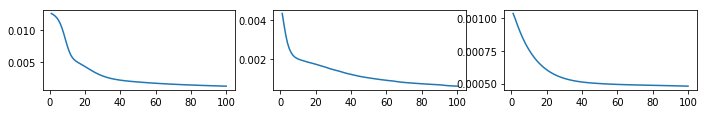

In [7]:
plt.clf()

tot = len(histories)
cols = 5
rows = tot//cols
rows += tot%cols

pos = range(1,tot+1)
print(tot)
fig = plt.figure(1, )
fig.set_figheight(5)
fig.set_figwidth(20)

for i,h in enumerate(histories):
    ax = fig.add_subplot(rows,cols,pos[i])
    loss = h.history['loss']
    epochs = range(1, len(loss)+1)
    ax.plot(epochs, loss)

plt.show()

In [8]:
history = autoencoder.fit(X,X, batch_size=512, epochs=200)

Epoch 1/200
20367/20367 [==============================] - 0s 18us/step - loss: 0.0121
Epoch 2/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0117
Epoch 3/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0110
Epoch 4/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0101
Epoch 5/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0093
Epoch 6/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0090
Epoch 7/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0089
Epoch 8/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0087
Epoch 9/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0085
Epoch 10/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0081
Epoch 11/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0074
Epoch 12/200
20367/20367 [===============

20367/20367 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 95/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 96/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 97/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0021
Epoch 98/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0021
Epoch 99/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0021
Epoch 100/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 101/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 102/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 103/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 104/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 105/200
20367/20367 [=============

20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 187/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 188/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 189/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 190/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 191/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 192/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 193/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 194/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 195/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 196/200
20367/20367 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 197/200
20367/20367 [========

In [9]:
autoencoder.save_weights('autoencoder.h5')

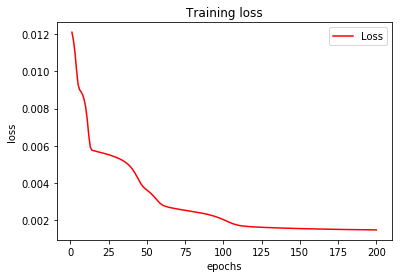

In [10]:
plt.clf()
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [11]:
#autoencoder.load_weights('autoencoder_smaller.h5')

In [12]:
for i,layer in enumerate(encoder.layers):
    layer.set_weights(autoencoder.layers[i].get_weights())

In [13]:
class ClusteringLayer(Layer): 
    
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha        
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]
        
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]
        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]
        
    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2/self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q
    
    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)
    
    def get_output_shape(self, input_shape):
        return self.get_output_shape(input_shape)
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.output_dim
    
    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items() + list(config.items)))
    

In [14]:
from sklearn.cluster import KMeans

cluster_centers = None
y_prediction = 0
n_clusters=3
# initialize cluster centres using k-means
print('Initializing cluster centres with k-means.')
if cluster_centers is None:
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_prediction = kmeans.fit_predict(encoder.predict(X))
    cluster_centers = kmeans.cluster_centers_


Initializing cluster centres with k-means.


In [15]:
model = Sequential([encoder,
                    ClusteringLayer(n_clusters,
                                    weights=cluster_centers,
                                    name='clustering')])

model.compile(optimizer='adadelta',
              loss='kullback_leibler_divergence')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 10)                1068010   
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 30        
Total params: 1,068,040
Trainable params: 1,068,040
Non-trainable params: 0
_________________________________________________________________


In [22]:
def p_mat(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

labels = {"av_pred_class_AFP": 0,
          "av_pred_class_NTP":1,
          "av_pred_class_PC":2}
def cluster_acc(y_truth, y_pred):
    yidx = y_truth.idxmax(1).values
    y_true = np.vectorize(labels.get)(yidx)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

In [17]:
y_prediction

array([2, 2, 2, ..., 2, 0, 0], dtype=int32)

In [18]:
batch_size = 512
y = ae_data_y.copy()
update_interval = X.shape[0]/batch_size
iteration = 0
index = 0
train_dec_epochs = 200
master_acc = []
save_interval = X.shape[0]/batch_size*50
# training loop
for i in range(train_dec_epochs):
    
    #if i % update_interval == 0:
    if True:
        q = model.predict(X, verbose=0)
        p = p_mat(q)
        y_pred = q.argmax(1)
        delta_label = ((y_pred != y_prediction).sum().astype(np.float32) / y_pred.shape[0])
        if y is not None:
            acc = cluster_acc(y, y_prediction)[0]
            master_acc.append(acc)
            print('Iteration '+str(i)+', Accuracy '+str(np.round(acc, 5)))
        else:
            print(str(np.round(delta_label*100, 5))+'%change in label assignment')
        print(str(np.round(delta_label*100, 5))+'%change in label assignment')            
        
        y_prediction = y_pred
        
    for i, layer in enumerate(encoder.layers):
        layer.set_weights(model.layers[0].layers[i].get_weights())
    cluster_centers = model.layers[-1].get_weights()[0]
    
    
    if(index+1)*batch_size > X.shape[0]:
        loss = model.train_on_batch(X[index*batch_size::], p[index*batch_size::],
                                    p[index*batch_size::])
        index = 0
    else:
        loss = model.train_on_batch(X[index*batch_size:(index+1) * batch_size],
                                    p[index*batch_size:(index+1) * batch_size])
        index += 1
    
    
    iteration +=1

        

[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 0, Accuracy 0.4497
0.0%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 1, Accuracy 0.4497
5.31252%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 2, Accuracy 0.48137
5.02774%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 3, Accuracy 0.45181
1.09%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 4, Accuracy 0.45809
1.9345%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 5, Accuracy 0.46958
0.38297%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 6, Accuracy 0.46747
2.34693%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred

[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 60, Accuracy 0.50047
1.635%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 61, Accuracy 0.49025
1.69392%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 62, Accuracy 0.50091
0.65793%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 63, Accuracy 0.49708
0.09329%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 64, Accuracy 0.49703
1.00653%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 65, Accuracy 0.50322
1.92468%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 66, Accuracy 0.51515
3.41729%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ..

[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 120, Accuracy 0.50096
2.93121%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 121, Accuracy 0.51878
1.53189%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 122, Accuracy 0.50945
1.00653%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 123, Accuracy 0.51633
0.02455%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 124, Accuracy 0.51628
0.10802%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 125, Accuracy 0.51569
1.15874%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 126, Accuracy 0.52163
1.92959%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  

[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 180, Accuracy 0.52448
2.01306%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 181, Accuracy 0.51235
1.42878%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 182, Accuracy 0.52124
0.95743%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 183, Accuracy 0.51525
1.39441%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 184, Accuracy 0.52364
1.33549%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 185, Accuracy 0.51564
2.32238%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  [0 1 1 ... 0 0 0]
Y_pred:  [2 2 2 ... 2 0 0]
Iteration 186, Accuracy 0.52939
3.19635%change in label assignment
[2 2 2 ... 2 0 0]
Y_True:  

In [40]:
from sklearn.decomposition import PCA
df = X.copy()

labels = {"AFP": 0,
          "NTP":1,
          "PC":2,
          "UNK":3}

int_labels = np.vectorize(labels.get)(kepler_data['av_training_set'])
df['labels'] = int_labels

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df.values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.57422534 0.11916057 0.11029974]


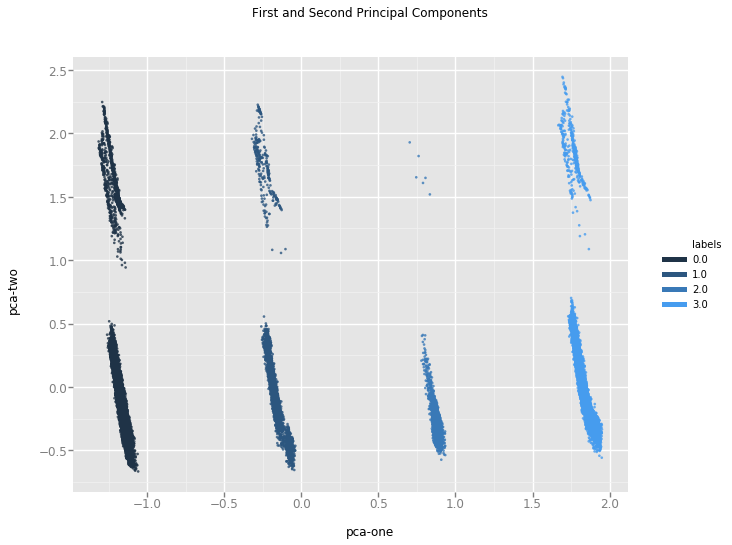

<ggplot: (-9223363290779232845)>

In [41]:
from ggplot import *

chart = ggplot( df, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=7,alpha=0.8) \
        + ggtitle("First and Second Principal Components")
chart

In [21]:
df.columns

Index(['tce_plnt_num', 'tce_period', 'tce_period_err', 'tce_time0bk',
       'tce_time0bk_err', 'tce_time0', 'tce_time0_err', 'tce_ror',
       'tce_ror_err', 'tce_dor', 'tce_dor_err', 'tce_incl', 'tce_incl_err',
       'tce_impact', 'tce_impact_err', 'tce_duration', 'tce_duration_err',
       'tce_ingress', 'tce_ingress_err', 'tce_depth', 'tce_depth_err',
       'tce_ldm_coeff1', 'tce_ldm_coeff2', 'tce_ldm_coeff3', 'tce_ldm_coeff4',
       'tce_num_transits', 'tce_full_conv', 'tce_model_snr', 'tce_model_chisq',
       'tce_model_dof', 'tce_robstat', 'tce_dof1', 'tce_dof2', 'tce_chisq1',
       'tce_chisq2', 'tce_prad', 'tce_prad_err', 'tce_sma', 'tce_sma_err',
       'tce_eqt', 'tce_eqt_err', 'tce_nkoi', 'tce_quarters', 'tce_steff',
       'tce_steff_err', 'tce_slogg', 'tce_slogg_err', 'tce_smet',
       'tce_smet_err', 'tce_sradius', 'tce_sradius_err', 'tce_mesmad',
       'tce_maxmes', 'tce_minmes', 'tce_maxmesd', 'tce_minmesd',
       'tce_max_sngle_ev', 'tce_max_mult_ev', 'tce_bin